# Getting the count matrix for RNA velocity

## Build reference genome for alevin

**Download the reference genome files**
>```bash
wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M24/gencode.vM24.annotation.gtf.gz
wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M24/GRCm38.primary_assembly.genome.fa.gz
gunzip GRCm38.primary_assembly.genome.fa.gz
>````

**Get intronic and intronic annotations**

>```bash
REFPATH=../data/references/gencode_GRCm38.vM24
Rscript ./build-alevin-ref.R ${REFPATH} generate 
>```

**Get file with chromosome names**
>```bash
grep ">" ${REFPATH}/GRCm38.primary_assembly.genome.fa | cut -d ">" -f 2 | cut -d " " -f 1 > ${REFPATH}/GRCm38.primary_assembly.genome.chrnames.txt
>````

**Build Salmon index**

>```bash
salmon index \
    -t <(cat {REFPATH}/gencode.vM24.annotation.expanded.fa ${REFPATH}/GRCm38.primary_assembly.genome.fa) \
    -i ${REFPATH}/gencode.vM24.annotation.expanded.sidx \
    --gencode \
    -p 32 \
    -d {REFPATH}/GRCm38.primary_assembly.genome.chrnames.txt
>```

**Create genome annotation file with tximeta**

>```bash
Rscript ./build-alevin-ref.R ${REFPATH} link
>```



## Count spliced and unspliced reads with alevin

>```bash
#!/usr/bin/bash
#SBATCH --account=rrg-hsn
#SBATCH --cpus-per-task=10
#SBATCH --mem=200gb
#SBATCH --time=20:00:00
#SBATCH --job-name=alevin
#SBATCH --err=logs/err.alevin.%j.log
#SBATCH --output=logs/out.alevin.%j.log
>FASTQTAG=/home/lmoral7/projects/rrg-hsn/lmoral7/micm-singlecell/fastq/neurons5k/SC3_v3_NextGem_DI_Neurons_5K_gex_S3_L00
>salmon alevin \
		-l A \
		-i ${REFPATH}/gencode.vM24.annotation.expanded.sidx \
		-1 ${FASTQTAG}1_R1_001.fastq.gz {FASTQTAG}2_R1_001.fastq.gz \
		-2 ${FASTQTAG}1_R2_001.fastq.gz ${FASTQTAG}2_R2_001.fastq.gz \
		-o ../output/alevin \
		-p 10 \
		--tgMap ${REFPATH}/gencode.vM24.annotation.expanded.tx2gene.tsv \
		--chromiumV3 \
		--dumpFeatures 
>```

## RNA velocity

In [14]:
import scvelo as scv
import loompy as lp
import pandas as pd
import numpy as np
import umap
import scanpy
from matplotlib import pyplot as plt
import pickle
from matplotlib import colors

In [15]:
scv.logging.print_version()
scv.settings.verbosity = 0  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.3 (python 3.8.8) on 2021-03-28 22:23.


## Preprocessing

In [16]:
adata = scv.read("../data/loom/a4.hgForebrainGlut.loom", cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


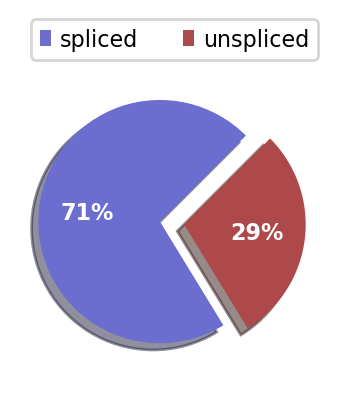

In [18]:
scv.pl.proportions(adata)

In [19]:
scv.pp.filter_and_normalize(adata,min_shared_counts=3,min_shared_cells=100)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Clustering

In [21]:
scanpy.tl.leiden(adata,0.6)

ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

## Estimations

In [ ]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.recover_latent_time(adata)
scv.tl.velocity_confidence(adata)
scv.tl.terminal_states(adata)
scv.tl.rank_velocity_genes(adata, groupby='leiden',n_genes=500)

## Visualizations

### Velocity embeddings

In [17]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='leiden',legend_loc='right')

KeyError: 'X_umap'

In [ ]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120,color='leiden',legend_loc='right')

### Velocity confidence

In [ ]:
scv.tl.velocity_confidence(adata)
tags = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=tags, cmap='coolwarm', perc=[2, 98])

# References
1. https://combine-lab.github.io/alevin-tutorial/2020/alevin-velocity/
2. https://salmon.readthedocs.io/en/latest/alevin.html
3. https://umi-tools.readthedocs.io/en/latest/Single_cell_tutorial.html